In [1]:
import numpy as np

import torch
import torchvision
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

/home/faris/miniconda3/envs/cudalab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Pipeline
  - Data:
      - Load dataset
      - DataLoader
      - Visualize dataset samples
  - Design Model:
      - Model Architecture
      - Forward Pass
  - Define Loss Function
  - Define Optimizer
  - Train:
      - Forward Pass (compute activations and loss)
      - Backward Pass (compute gradients)
      - Update Weights

# CIFAR10 Dataset

In [ ]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(type(train_dataset))
print(type(test_dataset))

<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [6]:
img_shape = train_dataset[0][0].shape
print(img_shape)

torch.Size([3, 32, 32])


In [7]:
label = train_dataset[0][1]
print(label)

6


# DataLoader

In [8]:
BATCH_SIZE = 256
SHUFFLE_TRAIN = True
SHUFFLE_TEST = False

In [9]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

In [10]:
eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

# Visualization

In [15]:
train_dataset[4][0]

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


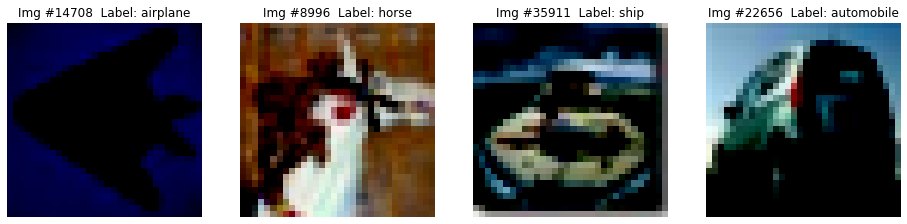

In [56]:
N_IMGS = 4
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(4 * N_IMGS, 4)

cifar10_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    #img = train_dataset[n][0].numpy().transpose(1, 2, 0)
    img = train_dataset[n][0].permute(1, 2, 0)
    label_idx = train_dataset[n][1]
    label_name = cifar10_labels[label_idx]
    
    ax[i].imshow(img)
    ax[i].set_title(f"Img #{n}  Label: {label_name}")
    ax[i].axis("off")
plt.show()

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=output_dim)
        )
        
    def forward(self, x):
        pred = self.layers(x)
        return pred

In [ ]:
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

# Training

In [ ]:
input_dim = train_dataset[0][0].flatten(start_dim=0).shape[0] # start_dim = 0 because this is not batch but a single sample
print(input_dim)

In [ ]:
NUM_EPOCHS = 20
LR = 0.01

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=input_dim, output_dim=10)
model = model.to(device)

In [ ]:
print(model)

In [ ]:
count_model_params(model)

In [ ]:
criterion = nn.CrossEntropyLoss() # already includes softmax (no need for softmax layer)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
training_loss = []

for epoch in range(NUM_EPOCHS):
    #progress_bar = tqdm(train_loader, total=len(train_loader))
    training_loss_epoch = 0.0
    
    for i, (imgs, labels) in enumerate(train_loader):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing loss (loss is Tensor of 1 element, loss.item() is scalar)
        loss = criterion(preds, labels)
        training_loss_epoch += loss.item()

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backpropagation - computing gradients
        loss.backward()
    
        # updating parameters/weights
        optimizer.step()

    training_loss_epoch = np.divide(training_loss_epoch, i+1)
    training_loss.append(training_loss_epoch)

    print("Epoch: " + str(epoch+1) + ", loss: " + str(training_loss_epoch))

# Loss Curve for Training Data

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18,5)

ax.plot(training_loss, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("CE Loss")
ax.set_title("Training Progress (linearscale)")

plt.show()

# Accuracy

In [ ]:
n_correct = 0

In [ ]:
with torch.no_grad():
    #progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in enumerate(train_loader): 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        pred_labels = torch.argmax(preds, dim=1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

In [ ]:
accuracy = n_correct / len(train_dataset) * 100
print(f"Training accuracy: {round(accuracy,2)}%")

In [ ]:
n_correct = 0

In [ ]:
with torch.no_grad():
    #progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in enumerate(eval_loader): 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        pred_labels = torch.argmax(preds, dim=1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

In [ ]:
accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

# Optuna - Hyperparameter Optimization

https://optuna.org/#code_examples

You can optimize PyTorch hyperparameters, such as the number of layers and the number of hidden nodes in each layer, in three steps: 

In [ ]:
import optuna